In [ ]:
pip install biopython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.0 MB/s eta 0:00:00


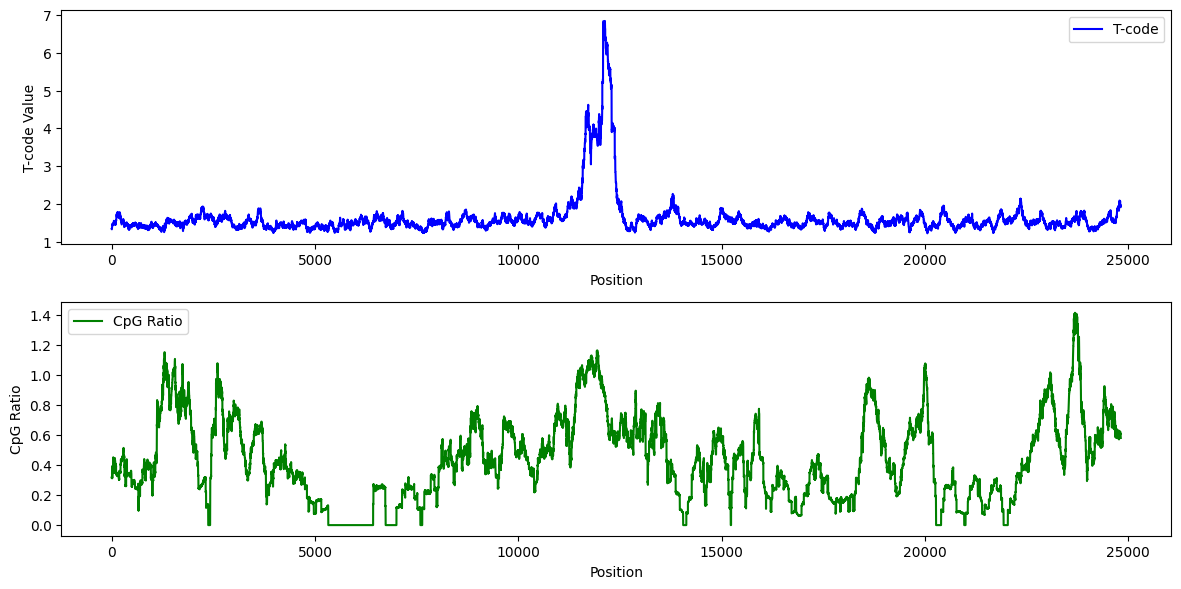

In [ ]:
import re
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt

def tcode(dna):
    counter = {
        1: {'A': 0, 'T': 0, 'G': 0, 'C': 0},
        2: {'A': 0, 'T': 0, 'G': 0, 'C': 0},
        3: {'A': 0, 'T': 0, 'G': 0, 'C': 0}
    }

    for i in range(0, len(dna) - 2, 3):
        codon = dna[i:i + 3]
        for j, nt in enumerate(codon):
            counter[j + 1][nt] += 1

    bases = ['A', 'T', 'G', 'C']
    atgcBias = {}

    for b in bases:
        count = [counter[p][b] for p in range(1, 4)]
        total = sum(count)
        comp = total / len(dna)
        sorted_counts = sorted(count)
        bias = (sorted_counts[-1]) / (sorted_counts[0] + 1)
        atgcBias[b] = (comp, bias)

    w = [0.11, 0.26, 0.14, 0.33, 0.15, 0.31, 0.12, 0.18]
    t = sum(w[i] * list(atgcBias.values())[i // 2][i % 2] for i in range(8))

    return t

def calculate_CpG(window):
    cg_count = len(re.findall("CG", window, re.IGNORECASE))
    c_count = len(re.findall("C", window, re.IGNORECASE))
    g_count = len(re.findall("G", window, re.IGNORECASE))
    CpG_ratio = (cg_count / len(window)) / ((c_count / len(window)) * (g_count / len(window)))
    return CpG_ratio

def analyze_fasta(fasta_path, window_size=300):
    results = []

    for record in SeqIO.parse(fasta_path, "fasta"):
        sequence = str(record.seq)

        for i in range(0, len(sequence) - window_size + 1):
            window = sequence[i:i + window_size]
            try:
                tcode_value = tcode(window)
                CpG_ratio = calculate_CpG(window)
                # Ensure each result entry has exactly three values
                results.append((i, tcode_value, CpG_ratio))
            except Exception as e:
                print(f"Skipping window at position {i} due to error: {e}")

    return results


def plot_analysis(results):
    positions, tcodes, CpG_ratios = zip(*results)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(positions, tcodes, label="T-code", color="blue")
    plt.xlabel("Position")
    plt.ylabel("T-code Value")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(positions, CpG_ratios, label="CpG Ratio", color="green")
    plt.xlabel("Position")
    plt.ylabel("CpG Ratio")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Upload the FASTA file
fasta_path = "/content/unknown_sequence2.fna"  # Replace with the path to your uploaded file
results = analyze_fasta(fasta_path)
plot_analysis(results)


In [ ]:
def find_max_tcode_position(results):
    """Find the position with the maximum T-code value."""
    max_tcode = max(results, key=lambda x: x[1])  # Find the tuple with the highest T-code value
    position, tcode_value, cpg_ratio = max_tcode
    print(f"Position with maximum T-code: {position}")
    print(f"Maximum T-code value: {tcode_value}")
    print(f"Corresponding CpG ratio: {cpg_ratio}")
    return position, tcode_value, cpg_ratio

# Find and display the position with the maximum T-code value
max_position, max_tcode_value, max_cpg_ratio = find_max_tcode_position(results)


Position with maximum T-code: 12131
Maximum T-code value: 6.841375523349438
Corresponding CpG ratio: 0.8618981573211809


Analyzing seq2


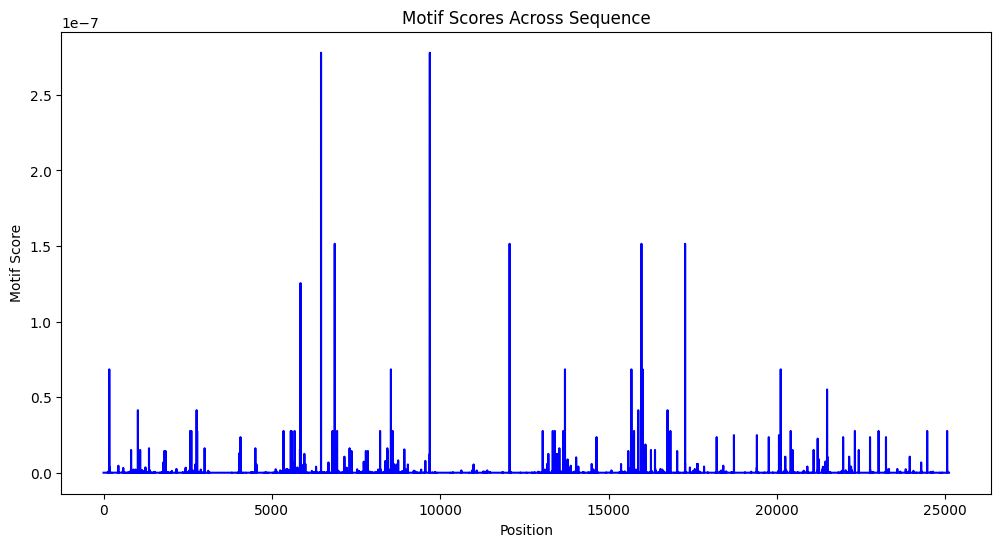

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO

def load_pssm(jaspar_path):
    """Load a JASPAR-style matrix and create a position-specific scoring matrix (PSSM)."""
    pssm = {}
    total_counts = 0

    with open(jaspar_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                # Skip header lines starting with ">"
                continue

            # Remove square brackets and split the line
            parts = line.replace("[", "").replace("]", "").split()
            base = parts[0]
            counts = list(map(int, parts[1:]))  # Read all numbers after the base
            pssm[base] = np.array(counts)
            total_counts += sum(counts)  # Sum all counts for the current base

    return pssm, total_counts



def calculate_motif_score(seq_window, pssm, total_counts):
    """Calculate the score for a given sequence window using the PSSM."""
    score = 1.0
    for position, base in enumerate(seq_window):
        if base in pssm:
            # Avoid zero probabilities by setting them to 1
            score *= max(pssm[base][position], 1) / total_counts
        else:
            # If there's a base not in the PSSM, set score to 0 (unlikely case for DNA)
            score = 0
            break
    return score

def analyze_fasta(fasta_path, pssm, total_counts):
    """Analyze the FASTA file for motif scores in each window that matches the PSSM size."""
    pssm_length = len(next(iter(pssm.values())))  # Get the number of columns in the PSSM
    results = []

    for record in SeqIO.parse(fasta_path, "fasta"):
        sequence = str(record.seq)
        header = record.id
        print(f"Analyzing {header}")

        for i in range(len(sequence) - pssm_length + 1):
            window = sequence[i:i + pssm_length]
            score = calculate_motif_score(window, pssm, total_counts)
            results.append((i, score))

    return results


    return results

def plot_results(results):
    """Plot the position vs motif score for visualization."""
    positions, scores = zip(*results)

    plt.figure(figsize=(12, 6))
    plt.plot(positions, scores, color="blue")
    plt.xlabel("Position")
    plt.ylabel("Motif Score")
    plt.title("Motif Scores Across Sequence")
    plt.show()

# Paths to your input files
jaspar_path = "/content/MA0108.3.jaspar"  # Replace with your JASPAR matrix file path
fasta_path = "/content/unknown_sequence2.fna"  # Replace with your FASTA file path

# Load the PSSM and process the FASTA file
pssm, total_counts = load_pssm(jaspar_path)
results = analyze_fasta(fasta_path, pssm, total_counts)
plot_results(results)



In [ ]:
# Modify the unpacking to match the structure returned by the function
max1_data, max2_data = find_two_max_scores(results)

# Unpack the individual elements (position and score) from each tuple
max1_position, max1_score = max1_data
max2_position, max2_score = max2_data

# Now you can use the values
print(f"First maximum score position: {max1_position}, score: {max1_score}")
print(f"Second maximum score position: {max2_position}, score: {max2_score}")


Position with first maximum score: 6460
First maximum score: 2.7786432225339873e-07
Position with second maximum score: 9692
Second maximum score: 2.7786432225339873e-07
First maximum score position: 6460, score: 2.7786432225339873e-07
Second maximum score position: 9692, score: 2.7786432225339873e-07


Analyzing seq2


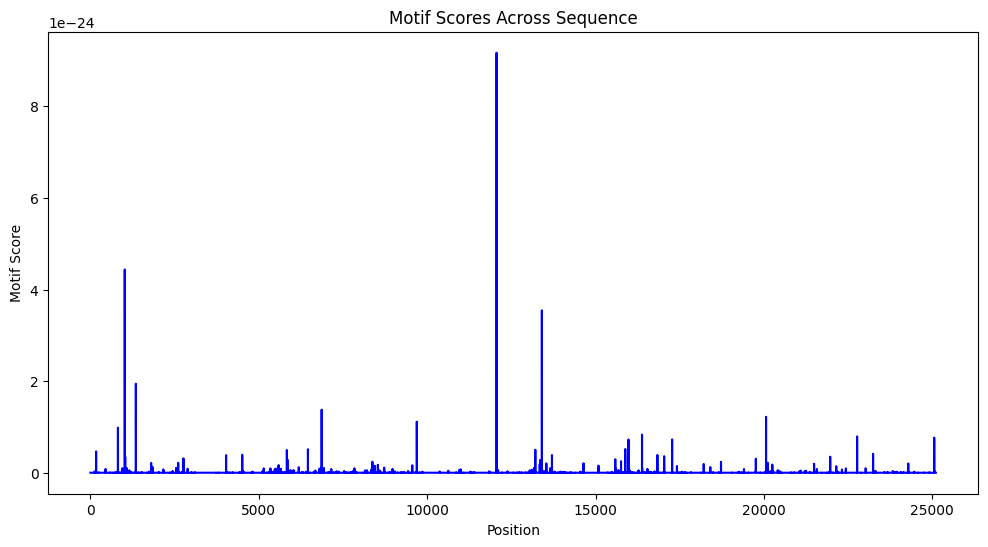

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO

def load_pssm(jaspar_path):
    """Load a JASPAR-style matrix and create a position-specific scoring matrix (PSSM)."""
    pssm = {}
    total_counts = 0

    with open(jaspar_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                # Skip header lines starting with ">"
                continue

            # Remove square brackets and split the line
            parts = line.replace("[", "").replace("]", "").split()
            base = parts[0]
            counts = list(map(int, parts[1:]))  # Read all numbers after the base
            pssm[base] = np.array(counts)
            total_counts += sum(counts)  # Sum all counts for the current base

    return pssm, total_counts



def calculate_motif_score(seq_window, pssm, total_counts):
    """Calculate the score for a given sequence window using the PSSM."""
    score = 1.0
    for position, base in enumerate(seq_window):
        if base in pssm:
            # Avoid zero probabilities by setting them to 1
            score *= max(pssm[base][position], 1) / total_counts
        else:
            # If there's a base not in the PSSM, set score to 0 (unlikely case for DNA)
            score = 0
            break
    return score

def analyze_fasta(fasta_path, pssm, total_counts):
    """Analyze the FASTA file for motif scores in each window that matches the PSSM size."""
    pssm_length = len(next(iter(pssm.values())))  # Get the number of columns in the PSSM
    results = []

    for record in SeqIO.parse(fasta_path, "fasta"):
        sequence = str(record.seq)
        header = record.id
        print(f"Analyzing {header}")

        for i in range(len(sequence) - pssm_length + 1):
            window = sequence[i:i + pssm_length]
            score = calculate_motif_score(window, pssm, total_counts)
            results.append((i, score))

    return results


    return results

def plot_results(results):
    """Plot the position vs motif score for visualization."""
    positions, scores = zip(*results)

    plt.figure(figsize=(12, 6))
    plt.plot(positions, scores, color="blue")
    plt.xlabel("Position")
    plt.ylabel("Motif Score")
    plt.title("Motif Scores Across Sequence")
    plt.show()

# Paths to your input files
jaspar_path = "/content/MA0108.2.jaspar"  # Replace with your JASPAR matrix file path
fasta_path = "/content/unknown_sequence2.fna"  # Replace with your FASTA file path

# Load the PSSM and process the FASTA file
pssm, total_counts = load_pssm(jaspar_path)
results = analyze_fasta(fasta_path, pssm, total_counts)
plot_results(results)


In [ ]:
def find_max_score_position(results):
    """Find the position with the maximum motif score."""
    # Assume the structure is (position, score, ...), and only take the first two elements
    max_score_data = max(results, key=lambda x: x[1])  # Find the tuple with the highest score
    position = max_score_data[0]  # First element as position
    max_score = max_score_data[1]  # Second element as score
    print(f"Position with maximum score: {position}")
    print(f"Maximum score: {max_score}")
    return position, max_score

# Find and display the position with the maximum motif score
max_position, max_score = find_max_score_position(results)


Position with maximum score: 12060
Maximum score: 9.171816400570501e-24


Analyzing seq2


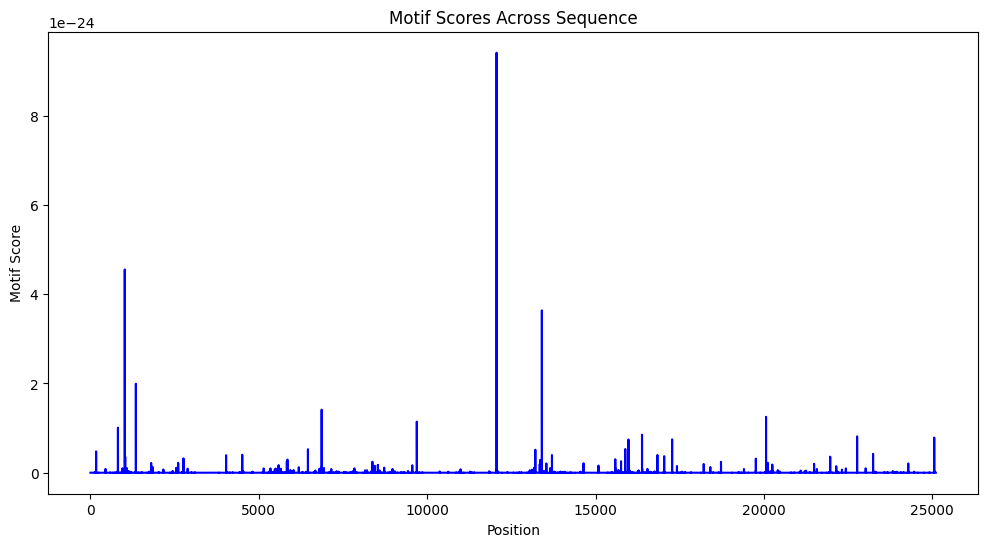

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO

def load_pssm(jaspar_path):
    """Load a JASPAR-style matrix and create a position-specific scoring matrix (PSSM)."""
    pssm = {}
    total_counts = 0

    with open(jaspar_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                # Skip header lines starting with ">"
                continue

            # Remove square brackets and split the line
            parts = line.replace("[", "").replace("]", "").split()
            base = parts[0]
            counts = list(map(int, parts[1:]))  # Read all numbers after the base
            pssm[base] = np.array(counts)
            total_counts += sum(counts)  # Sum all counts for the current base

    return pssm, total_counts



def calculate_motif_score(seq_window, pssm, total_counts):
    """Calculate the score for a given sequence window using the PSSM."""
    score = 1.0
    for position, base in enumerate(seq_window):
        if base in pssm:
            # Avoid zero probabilities by setting them to 1
            score *= max(pssm[base][position], 1) / total_counts
        else:
            # If there's a base not in the PSSM, set score to 0 (unlikely case for DNA)
            score = 0
            break
    return score

def analyze_fasta(fasta_path, pssm, total_counts):
    """Analyze the FASTA file for motif scores in each window that matches the PSSM size."""
    pssm_length = len(next(iter(pssm.values())))  # Get the number of columns in the PSSM
    results = []

    for record in SeqIO.parse(fasta_path, "fasta"):
        sequence = str(record.seq)
        header = record.id
        print(f"Analyzing {header}")

        for i in range(len(sequence) - pssm_length + 1):
            window = sequence[i:i + pssm_length]
            score = calculate_motif_score(window, pssm, total_counts)
            results.append((i, score))

    return results


    return results

def plot_results(results):
    """Plot the position vs motif score for visualization."""
    positions, scores = zip(*results)

    plt.figure(figsize=(12, 6))
    plt.plot(positions, scores, color="blue")
    plt.xlabel("Position")
    plt.ylabel("Motif Score")
    plt.title("Motif Scores Across Sequence")
    plt.show()

# Paths to your input files
jaspar_path = "/content/MA0108.1.jaspar"  # Replace with your JASPAR matrix file path
fasta_path = "/content/unknown_sequence2.fna"  # Replace with your FASTA file path

# Load the PSSM and process the FASTA file
pssm, total_counts = load_pssm(jaspar_path)
results = analyze_fasta(fasta_path, pssm, total_counts)
plot_results(results)


In [ ]:
def find_max_score_position(results):
    """Find the position with the maximum motif score."""
    # Assume the structure is (position, score, ...), and only take the first two elements
    max_score_data = max(results, key=lambda x: x[1])  # Find the tuple with the highest score
    position = max_score_data[0]  # First element as position
    max_score = max_score_data[1]  # Second element as score
    print(f"Position with maximum score: {position}")
    print(f"Maximum score: {max_score}")
    return position, max_score

# Find and display the position with the maximum motif score
max_position, max_score = find_max_score_position(results)


Position with maximum score: 12060
Maximum score: 9.410860001478741e-24
